
# Explaining Models with Conditional Data Imputation

This example notebook demonstrates how to use the `shapiq.ConditionalImputer` for conditional imputation of missing values in the context of Shapley interaction values and model-agnostic explanations.
To explain models with model-agnostic methods such as Shapley interactions, one first needs to make a model usable with partial information, i.e. missing feature values.
Usually, models do not allow for missing values (i.e. you cannot do inference with a neural network that was trained on 10 features if you provide only 9 features at inference time).
Therefore, one needs to impute missing values and allow for _feature removal_.

### Primer on Removal-Based Explanations

Feature removal is a component of removal-based explanations [(Covert et al., 2021)](https://jmlr.org/papers/v22/20-1316.html)., where the goal is to restrict the model $f: \mathcal X \to \mathcal Y$ on a $d$-dimensional input space $\mathcal X$ with features $D := \{1,\dots,d\}$ to a subset $S \subset D$, while preserving accuracy.
Formally, feature removal is executed by a function $F : \mathcal X \times \mathcal P(D) \to \mathcal Y$, where $\mathcal P(D)$ refers to the power set of $D$, which enables the evaluation of the model for unknown features in $\bar S := D \setminus S$.
While retraining the model on each subset $S \subseteq D$ of features is computationally prohibitive, we rely on a perturbation of the inputs of $\bar S$ for a given model $f$.
Yet, perturbing/imputing missing values is not trivial and can lead to inconsistencies different explanations. For a deep dive into this topic, we refer to [Frye et al., (2021)](https://openreview.net/pdf?id=OPyWRrcjVQw), [Chen et al., (2021)](https://arxiv.org/pdf/2006.16234), and [Fumagalli et al., (2023)](https://www.esann.org/sites/default/files/proceedings/2023/ES2023-148.pdf).

In general, one can distinguish between marginal (also known as _interventional_) and conditional imputation strategies (also known as _observational_):
- **Marginal Imputation:** Impute missing values independently of the other features, i.e. $F_{\text{marg.}}(x,S) := \mathbb{E}\left[f(x^{(S)},X^{(\bar S)})\right]$. This is the default imputation strategy in `shapiq`.
- **Conditional Imputation:** Impute missing values conditioned on the other features, i.e. $F_{\text{cond.}}(x,S) := \mathbb{E}\left[f(X) \mid X^{(S)} = x^{(S)}\right]$. This is the imputation strategy demonstrated in this notebook. `shapiq` uses a generative model approach to learn and predict the conditional distribution of the missing features.
 
We write $f(x^{(S)},x^{(\bar S)})$ to distinguish between inputs of $f$ in $S$, $x^{(S)}$, and inputs of $f$ in $\bar S$, $x^{(\bar S)}$.

For an illustration of this concept, see the following figure from [Fumagalli et al., (2023)](https://www.esann.org/sites/default/files/proceedings/2023/ES2023-148.pdf):

![Interventional_and_Observational_Removal](../images/int_obs.png)

Here, a synthetic data distribution (black dots) is overlayed with a marginal (blue pluses) and conditional (red crosses) imputations of missing values.
The data distribution shows a _high dependency_ between the two features (_salary_ and _commission_). 
People with a salary of $>75k$ have no commission, while people with a salary of $<75k$ have a commission of $>0$.
The blue pluses can create data points that lie outside the original data distribution, while the red crosses are more likely to lie within the original data distribution.

If we would have trained a model on the original data distribution, the blue pluses are odd and out of place. The model might not be well suited to work with these data points and would likely give wrong predictions. 
This could lead to wrong explanations, as the model would be forced to make predictions on data points that are unrealistic.

### Import Modules

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'1.2.3'

### Load Data
In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### Train a Model
We train a random forest regressor on the California housing dataset to explain the model with conditional imputation.
The model achieves a relatively good fit in terms of the $R^2$ score.

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7990
Test  R2: 0.7462


### Conditional Imputation for Model-Agnostic Explanations

As discussed in the preamble, we use `shapiq.ConditionalImputer` instead of `shapiq.MarginalImputer` in `shapiq.TabularExplainer` to take into account feature dependence.
It has the following key attributes:

- `sample_size`: The number of samples to draw from the conditional background data for imputation. Defaults to `10`.
- `conditional_budget`: The number of coallitions to sample per each point in `data` for training the generative model. Defaults to `16`.
- `conditional_threshold`: A quantile threshold defining a neighbourhood of samples to draw `sample_size` from. A value between `0.0` and `1.0`. Defaults to `0.05`.
- `random_state`: The random state to use for sampling. Defaults to `None`.

Use `imputer="conditional"` in `shapiq.TabularExplainer` and pass these attributes as `**kwargs`. 

In [4]:
explainer = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,
    # attributes of the imputer
    imputer="conditional",
    sample_size=100,
    conditional_budget=32,
    conditional_threshold=0.04,
)

**Note that** the initialization of conditional imputation will take some time, which is different from the marginal imputation (`imputer="marginal"`).
This additional time is due to the training of the generative model for conditional imputation.
In the background, a gradient boosting regressor from `xgboost.XGBRegressor` is trained to predict the feature values of each feature based on the remaining features.
Hence, the initialization time scales with the number of features.

Next, select we an instance to be explained.

In [5]:
x_explain = X_test[100]

Call an `explain()` interface setting `random_state` for reproducible approximation.

In [6]:
interaction_values = explainer.explain(x_explain, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0699756848160713
)

Visualize the explanation.

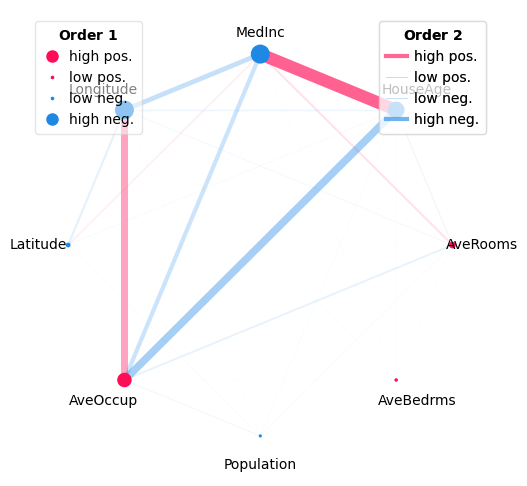

In [7]:
_ = shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

Increasing the `conditional_budget` will increase the initialization time of `shapiq.ConditionalImputer`, but should yield more accurate approximation of the conditional distribution used for the imputation of missing values.

In [8]:
explainer_longer = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,
    # attributes of the imputer
    imputer="conditional",
    sample_size=100,
    conditional_budget=256,  # was 32 before
    conditional_threshold=0.04,
)

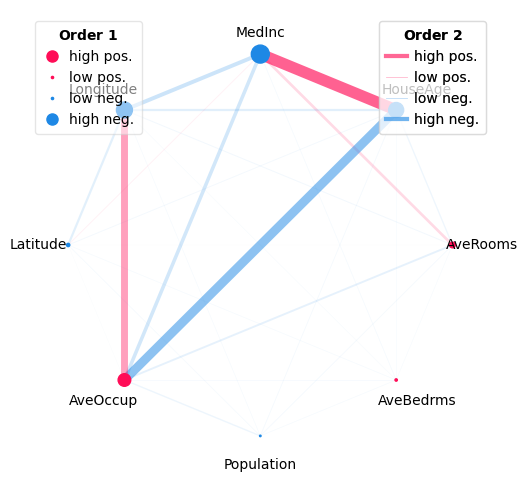

In [9]:
iv_longer = explainer_longer.explain(x_explain, random_state=0)
_ = shapiq.network_plot(
    first_order_values=iv_longer.get_n_order_values(1),
    second_order_values=iv_longer.get_n_order_values(2),
    feature_names=X.columns,
)

Likewise, increasing the `sample_size` will increase the computation time of `explain()`, but should yield a more accurate approximation of the Shapley interactions.

In [10]:
explainer_longer._imputer.sample_size = 500

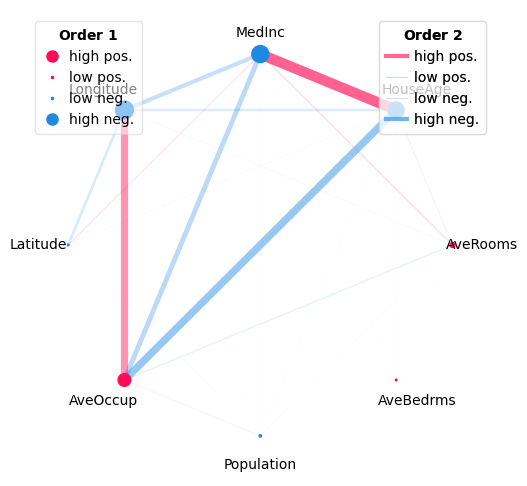

In [11]:
iv_even_longer = explainer_longer.explain(x_explain, random_state=0)
_ = shapiq.network_plot(
    first_order_values=iv_even_longer.get_n_order_values(1),
    second_order_values=iv_even_longer.get_n_order_values(2),
    feature_names=X.columns,
)

### Details
For further details, see the API reference of [shapiq.ConditionalImputer](https://shapiq.readthedocs.io/en/latest/api/shapiq.games.html#shapiq.games.ConditionalImputer). 

## References
Chen et al. (2021). True to the model or true to the data?. In CoRR. https://arxiv.org/pdf/2006.16234

Covert et al. (2021). Explaining by Removing: A Unified Framework for Model Explanation. In JMLR 22(209):1-90. https://jmlr.org/papers/v22/20-1316.html

Frye et al. (2021). Shapley explainability on the data manifold. In ICML'2021. https://openreview.net/pdf?id=OPyWRrcjVQw

Fumagalli et al. (2023). On Feature Removal for Explainability in Dynamic Environments. In ESANN'2023. https://www.esann.org/sites/default/files/proceedings/2023/ES2023-148.pdf